In [182]:
import cv2
import os
import numpy as np
import matplotlib.pyplot as plt
from skimage.measure import find_contours

## Part 1: transformation

### overlap scoring

In [2]:
def calculate_overlap(mask1, mask2):
    intersection = cv2.bitwise_and(mask1, mask2)
    union = cv2.bitwise_or(mask1, mask2)
    return np.sum(intersection) / np.sum(union)

### pre-processing masks

In [3]:

# Clean edges using morphological operations
def clean_edges(edges):
    blurred = cv2.GaussianBlur(edges, (5, 5), 0)
    dilated = cv2.dilate(blurred, np.ones((3, 3), np.uint8), iterations=1)
    cleaned_edges = cv2.erode(dilated, np.ones((3, 3), np.uint8), iterations=1)
    return cleaned_edges

# Find the largest contour by area
def find_largest_contour(contours):
    largest_contour = max(contours, key=cv2.contourArea)
    return largest_contour

# Fill a contour to create a mask of the shape
def fill_contour(img_shape, contour):
    mask = np.zeros(img_shape, dtype=np.uint8)
    cv2.drawContours(mask, [contour], -1, 255, thickness=cv2.FILLED)
    return mask

# Calculate the center of mass of a filled contour
def get_center_of_mass(mask):
    M = cv2.moments(mask)
    if M["m00"] != 0:
        cX = int(M["m10"] / M["m00"])
        cY = int(M["m01"] / M["m00"])
    else:
        cX, cY = mask.shape[1] // 2, mask.shape[0] // 2  # Default to center if no mass
    return cX, cY

# Center the image based on center of mass (centering in both axes)
def center_image(mask):
    cX, cY = get_center_of_mass(mask)
    shiftX = mask.shape[1] // 2 - cX
    shiftY = mask.shape[0] // 2 - cY
    translation_matrix = np.float32([[1, 0, shiftX], [0, 1, shiftY]])
    centered_mask = cv2.warpAffine(mask, translation_matrix, (mask.shape[1], mask.shape[0]))
    return centered_mask

# Combines functions above
def mask(tif_path):
    image = cv2.imread(tif_path, 0)
    edges = cv2.Canny(image, 50, 100)
    cleaned_edges = clean_edges(edges)
    contours, _ = cv2.findContours(cleaned_edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    largest_contour = find_largest_contour(contours)
    mask = fill_contour(cleaned_edges.shape, largest_contour)
    centered_mask = center_image(mask)
    return centered_mask

In [69]:
# Pad an image symmetrically to match the target size
def pad_to_size(image, target_size):
    # Check the number of dimensions in the image
    if len(image.shape) == 2:
        # Grayscale image (2D)
        h, w = image.shape
    elif len(image.shape) == 3:
        # Color image (3D)
        h, w, c = image.shape  # c is the number of channels (e.g., 3 for RGB)
    else:
        raise ValueError("Unsupported image dimensions")

    # Calculate padding
    pad_top = (target_size[1] - h) // 2
    pad_bottom = target_size[1] - h - pad_top
    pad_left = (target_size[0] - w) // 2
    pad_right = target_size[0] - w - pad_left

    # Apply padding
    if len(image.shape) == 2:
        # Grayscale image padding (2D)
        padded_image = np.pad(image, ((pad_top, pad_bottom), (pad_left, pad_right)), mode='constant', constant_values=0)
    elif len(image.shape) == 3:
        # Color image padding (3D)
        padded_image = np.pad(image, ((pad_top, pad_bottom), (pad_left, pad_right), (0, 0)), mode='constant', constant_values=0)
    
    return padded_image

### rotate, flip, translate

In [70]:
# Rotate image
def rotate_image(image, angle):
    h, w = image.shape[:2]
    center = (w // 2, h // 2)
    rotation_matrix = cv2.getRotationMatrix2D(center, angle, 1.0)
    rotated_image = cv2.warpAffine(image, rotation_matrix, (w, h))
    return rotated_image

# Flip image horizontally or vertically
def flip_image(image, flip_type):
    if flip_type == 'horizontal':
        return cv2.flip(image, 1)
    elif flip_type == 'vertical':
        return cv2.flip(image, 0)
    else:
        return image

# Translate image by (tx, ty) pixels
def translate_image(image, tx, ty):
    translation_matrix = np.float32([[1, 0, tx], [0, 1, ty]])
    translated_image = cv2.warpAffine(image, translation_matrix, (image.shape[1], image.shape[0]))
    return translated_image

### transformation pipeline

In [224]:
def pipeline_transformation(path1, path2, path3):
    # Load the masks
    mask1 = mask(path1)
    mask2 = mask(path2)
    mask3 = mask(path3)

    # Get maximum width and height to resize all three images
    max_width = max(mask1.shape[1], mask2.shape[1], mask3.shape[1])
    max_height = max(mask1.shape[0], mask2.shape[0], mask3.shape[0])

    # Resize and pad all masks to the same size
    mask1 = pad_to_size(mask1, (max_width, max_height))
    mask2 = pad_to_size(mask2, (max_width, max_height))
    mask3 = pad_to_size(mask3, (max_width, max_height))

    # Calculate the original similarity scores for mask2 and mask3
    original_similarity_2 = calculate_overlap(mask1, mask2)
    original_similarity_3 = calculate_overlap(mask1, mask3)

    # Initialize variables
    best_similarity_2 = original_similarity_2
    best_similarity_3 = original_similarity_3
    best_mask2 = mask2
    best_mask3 = mask3
    best_transformation_2 = (0, None, 0, 0)
    best_transformation_3 = (0, None, 0, 0)
    max_tx = int(0.02 * max_width)  # ±2% of width 
    max_ty = int(0.02 * max_height)  # ±2% of height

    # Step 4: Test flips and rotations before applying translations
    for flip in [None, 'horizontal', 'vertical']:  # Flip types
        for angle in range(0, 360, 15):  # Rotation angles from 0° to 360° in 15° intervals
            # Apply the rotation to both masks
            rotated_mask2 = rotate_image(mask2, angle)
            rotated_mask3 = rotate_image(mask3, angle)

            # Apply flip (if any)
            if flip == 'horizontal':
                rotated_mask2 = cv2.flip(rotated_mask2, 1)  # Flip horizontally
                rotated_mask3 = cv2.flip(rotated_mask3, 1)  # Flip horizontally
            elif flip == 'vertical':
                rotated_mask2 = cv2.flip(rotated_mask2, 0)  # Flip vertically
                rotated_mask3 = cv2.flip(rotated_mask3, 0)  # Flip vertically

            # Track the similarity after each transformation step
            current_similarity_2 = calculate_overlap(mask1, rotated_mask2)
            current_similarity_3 = calculate_overlap(mask1, rotated_mask3)

            # Only update masks and transformations if the similarity improves
            if current_similarity_2 > best_similarity_2:
                best_similarity_2 = current_similarity_2
                best_transformation_2 = (angle, flip, 0, 0)  # Rotation and flip only
                best_mask2 = rotated_mask2

            if current_similarity_3 > best_similarity_3:
                best_similarity_3 = current_similarity_3
                best_transformation_3 = (angle, flip, 0, 0)  # Rotation and flip only
                best_mask3 = rotated_mask3

            # Now, apply translations (with a finer step size, e.g., 50 pixels)
            for tx in range(-max_tx, max_tx + 1, 50):  # Translation in x, 50-pixel step
                for ty in range(-max_ty, max_ty + 1, 50):  # Translation in y, 50-pixel step
                    # Apply translation to the best current transformations
                    translated_mask2 = translate_image(best_mask2, tx, ty)
                    translated_mask3 = translate_image(best_mask3, tx, ty)

                    # Calculate similarity score between mask1 and the transformed masks
                    similarity_score_2 = calculate_overlap(mask1, translated_mask2)
                    similarity_score_3 = calculate_overlap(mask1, translated_mask3)

                    # Only apply the translation if the similarity score improves
                    if similarity_score_2 > best_similarity_2:
                        best_similarity_2 = similarity_score_2
                        best_transformation_2 = (best_transformation_2[0], best_transformation_2[1], tx, ty)
                        best_mask2 = translated_mask2

                    if similarity_score_3 > best_similarity_3:
                        best_similarity_3 = similarity_score_3
                        best_transformation_3 = (best_transformation_3[0], best_transformation_3[1], tx, ty)
                        best_mask3 = translated_mask3

    results_dict = {
        'startsim2': original_similarity_2,
        'startsim3': original_similarity_3,
        'endsim2': best_similarity_2,
        'endsim3': best_similarity_3,
        'trans2': best_transformation_2,
        'trans3': best_transformation_3
    }

    # Step 5: Return the results (best transformation and final masks)
    print(f"mask1 and mask2 similarity:")
    print(f"Start: {original_similarity_2:.4f}")
    print(f"End: {best_similarity_2:.4f}")

    print(f"\nmask1 and mask3 similarity:")
    print(f"Startl: {original_similarity_3:.4f}")
    print(f"Endl: {best_similarity_3:.4f}")

    return mask1, mask2, mask3, best_mask2, best_mask3, results_dict

In [225]:
paths = ['h1849462/h&e_ROI_3.tif', 'h1849462/melan a_ROI_1.tif', 'h1849462/sox10_ROI_1.tif']
he, melana, sox, m_optimal, s_optimal, results_dict = pipeline_transformation(paths[0], paths[1], paths[2])

mask1 and mask2 similarity:
Start: 0.4818
End: 0.6656

mask1 and mask3 similarity:
Startl: 0.0369
Endl: 0.0454


### transformation visualizations

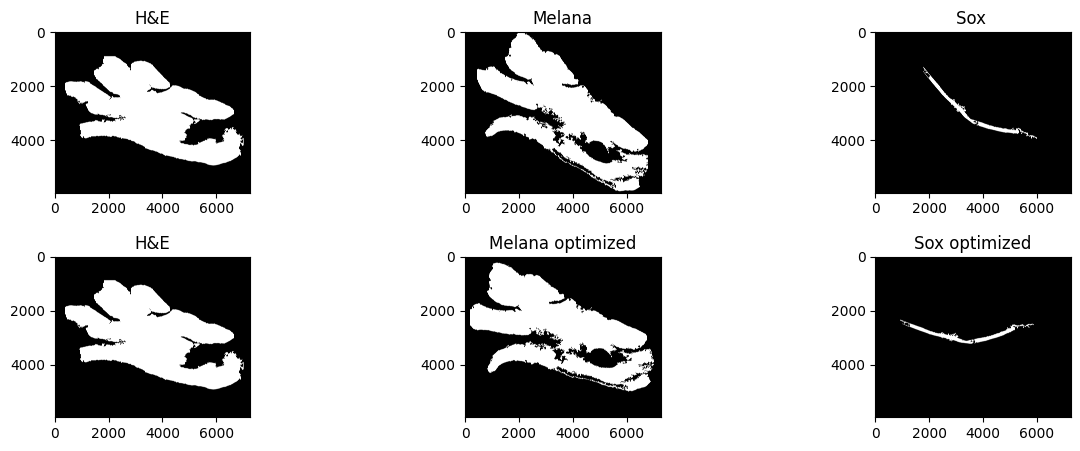

In [226]:
plt.figure(figsize=(15, 5))

plt.subplot(2, 3, 1)
plt.title('H&E')
plt.imshow(he, cmap='gray')

plt.subplot(2, 3, 2)
plt.title(f'Melana')
plt.imshow(melana, cmap='gray')

plt.subplot(2, 3, 3)
plt.title(f'Sox ')
plt.imshow(sox, cmap='gray')

plt.subplot(2, 3, 4)
plt.title('H&E')
plt.imshow(he, cmap='gray')

plt.subplot(2, 3, 5)
plt.title(f'Melana optimized')
plt.imshow(m_optimal, cmap='gray')

plt.subplot(2, 3, 6)
plt.title(f'Sox optimized')
plt.imshow(s_optimal, cmap='gray')

# Adjust spacing between subplots
plt.subplots_adjust(hspace=0.4)

plt.show()

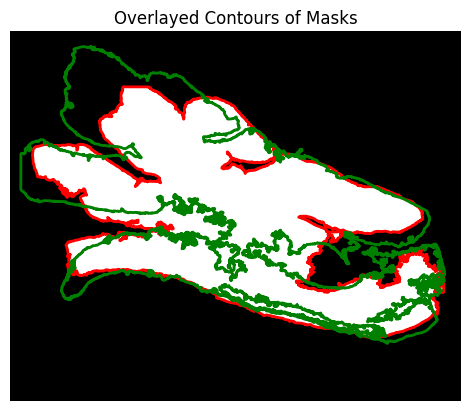

In [227]:
# Find contours for each mask
he_contours = find_contours(he, level=0.5)
melana_contours = find_contours(m_optimal, level=0.5)
sox_contours = find_contours(s_optimal, level=0.5)

# Plot the base image (you can choose to use one of the images or any other background)
plt.imshow(he, cmap='gray')  # Replace `he` with the desired base image

# Plot contours of each mask on top of the base image
for contour in he_contours:
    plt.plot(contour[:, 1], contour[:, 0], color='red', lw=2)  # Red contours for H&E

for contour in melana_contours:
    plt.plot(contour[:, 1], contour[:, 0], color='green', lw=2)  # Green contours for melana

# Customize plot (optional)
plt.title('Overlayed Contours of Masks')
plt.axis('off')  # Hide axis
plt.show()

## Part 2: patching

### apply transformations to tifs

In [228]:
def rotate_image2(image, angle):
    # Get the dimensions of the image
    h, w = image.shape[:2]
    
    # Calculate the center of the image
    center = (w // 2, h // 2)
    
    # Calculate the rotation matrix
    rotation_matrix = cv2.getRotationMatrix2D(center, angle, 1.0)
    
    # Calculate the new dimensions of the rotated image (to avoid cropping)
    abs_cos = abs(rotation_matrix[0, 0])
    abs_sin = abs(rotation_matrix[0, 1])
    new_w = int(h * abs_sin + w * abs_cos)
    new_h = int(h * abs_cos + w * abs_sin)
    
    # Adjust the rotation matrix to account for translation (to keep the image centered)
    rotation_matrix[0, 2] += (new_w / 2) - center[0]
    rotation_matrix[1, 2] += (new_h / 2) - center[1]
    
    # Perform the rotation
    rotated_image = cv2.warpAffine(image, rotation_matrix, (new_w, new_h), borderMode=cv2.BORDER_CONSTANT, borderValue=(0, 0, 0))
    
    return rotated_image

def transform_image(path, transformation):
    image = cv2.imread(path, cv2.IMREAD_COLOR)
    angle2, flip2, tx2, ty2 = transformation
    
    transformed_image = rotate_image2(image, angle2)  # Rotate
    transformed_image = flip_image(transformed_image, flip2)  # Flip
    transformed_image = translate_image(transformed_image, tx2, ty2)  # Translate

    return transformed_image

### get patches

In [229]:
def image_center(image):
    h, w = image.shape[:2]  # Get the height and width of the image
    center_x = w // 2
    center_y = h // 2
    return center_x, center_y

def get_patches(image, coord_list, square_size=200):
    center_x, center_y = image_center(image)  # Get the center of the image
    patches = []  # This will store the dictionary of square cutouts
    
    for coord in coord_list:
        # Calculate the bottom-left and top-right corners of the square based on the center and offsets
        bottom_left = (center_x + coord[0] - square_size // 2, center_y + coord[1] - square_size // 2)
        top_right = (bottom_left[0] + square_size, bottom_left[1] + square_size)
        
        # Extract the square as a cutout from the image (ROI)
        x1, y1 = bottom_left
        x2, y2 = top_right
        square_cutout = image[y1:y2, x1:x2]
        
        # Store the cutout
        patches.append(square_cutout)

        # Draw the cutout
        cv2.rectangle(image, bottom_left, top_right, (0, 0, 0), thickness=5)
    
    return image, patches

In [230]:
def display_tissues(image1, image2, image3, patient):
    plt.figure(figsize=(15, 5))  # Adjust size as needed

    # Display image1
    plt.subplot(1, 3, 1)  # 1 row, 3 columns, first image
    plt.imshow(cv2.cvtColor(image1, cv2.COLOR_BGR2RGB))  # Convert BGR to RGB for correct color display
    plt.title("H&E")  # Title for the first image
    plt.axis('off')  # Hide axes

    # Display image2
    plt.subplot(1, 3, 2)  # 1 row, 3 columns, second image
    plt.imshow(cv2.cvtColor(image2, cv2.COLOR_BGR2RGB))  # Convert BGR to RGB
    plt.title("Melana")  # Title for the second image
    plt.axis('off')  # Hide axes

    # Display image3
    plt.subplot(1, 3, 3)  # 1 row, 3 columns, third image
    plt.imshow(cv2.cvtColor(image3, cv2.COLOR_BGR2RGB))  # Convert BGR to RGB
    plt.title("Sox 10")  # Title for the third image
    plt.axis('off')  # Hide axes

    plt.suptitle(patient, fontsize=16, fontweight='bold')
    plt.tight_layout()  # Automatically adjust subplots to fit
    plt.show()

def display_patches(patches_dict, patient):
    # Create a figure with multiple subplots 
    num_squares = len(patches_dict)
    
    # Calculate the number of rows required (one row for each key in merged_squares)
    fig, axes = plt.subplots(num_squares, 3, figsize=(6, 2 * num_squares))
    
    if num_squares == 1:  # To handle the case of just a single row
        axes = [axes]
    
    # Iterate over each coordinate and corresponding squares (from image1, image2, and image3)
    for i, (coord, squares) in enumerate(patches_dict.items()):
        square1, square2, square3 = squares
        
        # Plot the squares in the corresponding subplots (3 squares per row)
        # Plot the first square from image1
        axes[i][0].imshow(cv2.cvtColor(square1, cv2.COLOR_BGR2RGB))
        axes[i][0].axis('off')
        axes[i][0].set_title(f"{coord}: H&E", fontsize=10)
        
        # Plot the second square from image2
        axes[i][1].imshow(cv2.cvtColor(square2, cv2.COLOR_BGR2RGB))
        axes[i][1].axis('off')
        axes[i][1].set_title(f"{coord}: Melana", fontsize=10)
        
        # Plot the third square from image3
        axes[i][2].imshow(cv2.cvtColor(square3, cv2.COLOR_BGR2RGB))
        axes[i][2].axis('off')
        axes[i][2].set_title(f"{coord}: Sox 10", fontsize=10)

    fig.suptitle(patient, fontsize=12, fontweight='bold')
    plt.tight_layout()
    plt.show()


### patching pipeline

In [231]:
def pipeline_patches(paths_dict, results_dict, coord_list, square_size=400, display=True):
    key = list(paths_dict.keys())[0]

    image1 = cv2.imread(paths_dict[key][0], cv2.IMREAD_COLOR)
    image2 = transform_image(paths_dict[key][1], results_dict['trans2'])
    image3 = transform_image(paths_dict[key][2], results_dict['trans3'])

    transformed1, squares1 = get_patches(image1, coord_list, square_size=square_size)
    transformed2, squares2 = get_patches(image2, coord_list, square_size=square_size)
    transformed3, squares3 = get_patches(image3, coord_list, square_size=square_size)

    patches_dict = {}

    for i, coord in enumerate(coord_list):
        # Each coordinate corresponds to a square in squares1, squares2, and squares3
        square1 = squares1[i]  # Square from image1
        square2 = squares2[i]  # Square from image2
        square3 = squares3[i]  # Square from image3
        
        # Store in the dictionary with the coordinate as the key and the tuple of squares as the value
        patches_dict[coord] = (square1, square2, square3)

    if display:
        display_tissues(transformed1, transformed2, transformed3, key)
        display_patches(patches_dict, key)

    return image1, image2, image3, patches_dict

In [232]:
paths_test = {}
paths_test['h1849462'] = paths
paths_test

coord_list = [(1000, 1000), (-2000, -500), (0, 0)]

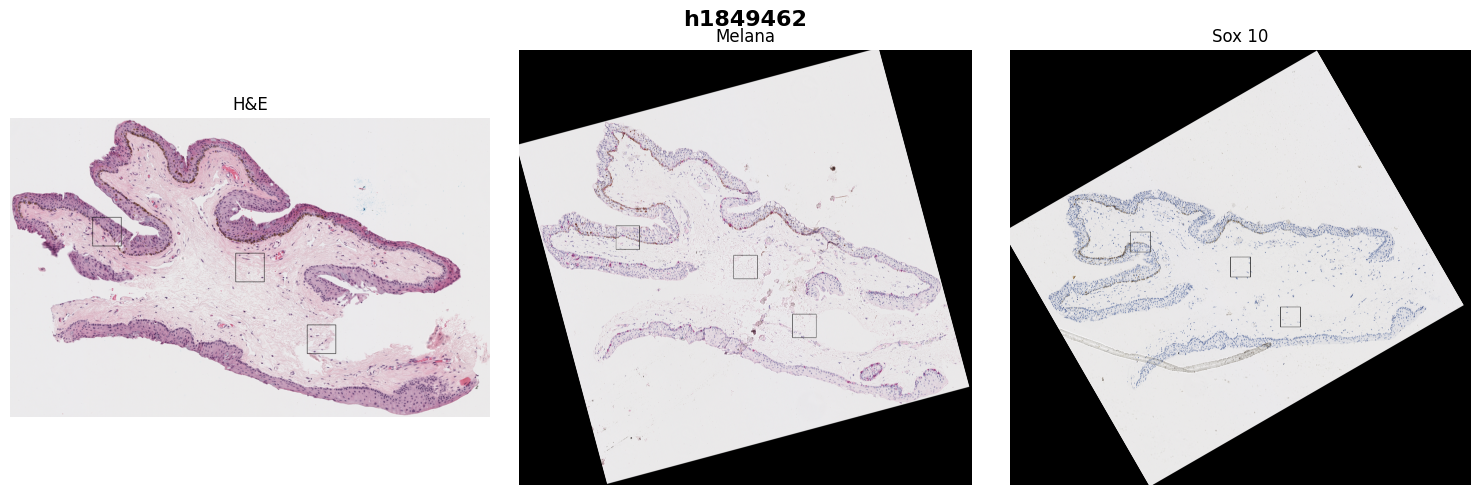

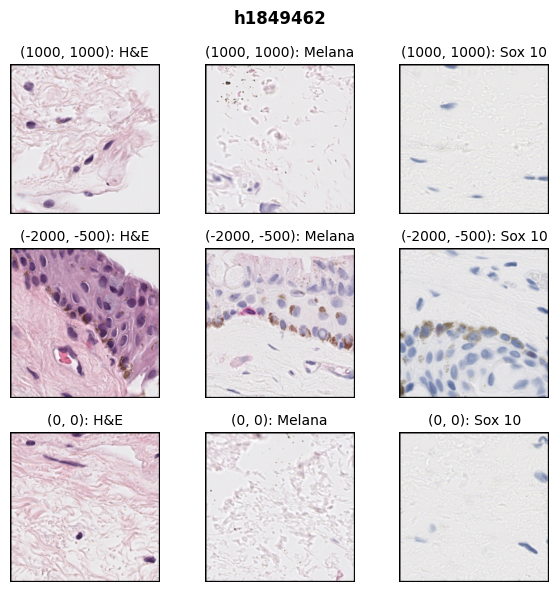

In [233]:
image1, image2, image3, patches_dict = pipeline_patches(paths_test, results_dict, coord_list)

## Part 3: automate

In [234]:
paths_test

{'h1849462': ['h1849462/h&e_ROI_3.tif',
  'h1849462/melan a_ROI_1.tif',
  'h1849462/sox10_ROI_1.tif']}

In [236]:
coord_dict = {}
coord_dict['h1849462'] = coord_list
coord_dict

{'h1849462': [(1000, 1000), (-2000, -500), (0, 0)]}

In [ ]:
def pipeline(paths_dict, coord_list, square_size=400, display=True):
    for lst in paths_dict:
        __, __, __, __, __, results_dict = pipeline_transformation(lst[0], lst[1], lst[2])
        image1, image2, image3, patches_dict= pipeline_patches(paths_dict, results_dict, coord_list, square_size=square_size, display=display)